# Tools

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

import glob
tf.random.set_seed(10)

## Building and annoting the dataset

## Extract Data

In [2]:
# initialization
x_test = []
y_test = [0,1,1,0,1,1,1,1,0,0] # "0": Field, "1": Road
road_im = []
field_im = []

# Define the path of each class of image
road_path = "./dataset/roads/"
field_path = "./dataset/fields/"
test_path = "./dataset/test_images/"

# Extract the name of images in each class folder
road_names = [*glob.glob(road_path + "*jpg" ), *glob.glob(road_path + "*jpeg" )]
field_names = glob.glob(field_path + "*jpg")
test_names = glob.glob(test_path + "*jpeg")

width = 256//2
height =  144//2
# remove the special caracter '\\' and build the data set in the same loop
for i in range(len(road_names)):
    road_names[i] =  road_names[i].replace('\\', '/')
    # load the image in the environment
    img = Image.open(road_names[i])
    # resize all the images to one size in order to use a unique classifier
    img = img.resize((width, height))
    # add the image array to the train data base
    road_im.append(np.asarray(img))
    


for i in range(len(field_names)):
    field_names[i] =  field_names[i].replace('\\', '/')
    img = Image.open(field_names[i])
    img = img.resize((width, height))
    field_im.append(np.asarray(img))

# for the test dataset the annotation is manuel because there is only 10 images
for i in range(len(test_names)):
    test_names[i] =  test_names[i].replace('\\', '/')
    img = Image.open(test_names[i])
    img = img.resize((width, height))
    x_test.append(np.asarray(img))

    
# print the number of files we have
print(" Number of images in the road file : ", len(road_names))
print(" Number of  images in the field file : ", len(field_names))
print(" Number of  images in the test file : ",len(x_test))

 Number of images in the road file :  110
 Number of  images in the field file :  43
 Number of  images in the test file :  10


### 1 - Subsampling the majority class

In [3]:
# subsampling the road class images
x_train_sub = np.concatenate((road_im[0:len(field_im)], field_im), axis= 0)
y_train_sub = np.concatenate((np.ones(len(road_im) - len(field_im)), np.zeros(len(field_im))))

# shuffle the data 
zipped = list(zip(x_train_sub, y_train_sub))
random.shuffle(zipped)
x_train_sub, y_train_sub = zip(*zipped)

# transform to ndarrays
x_train_sub = np.array(x_train_sub)
x_test = np.array(x_test)
y_train_sub = np.array(y_train_sub)
y_test = np.array(y_test)

# Normalize the data
x_train_sub = x_train_sub.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# transform labels to categorical form
print(y_train_sub.shape)
y_train_sub = tf.keras.utils.to_categorical(y_train_sub, num_classes=2)
y_test = tf.keras.utils.to_categorical(np.array(y_test), num_classes=2)


# Data shapes
print("x_train shape:", x_train_sub.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train_sub.shape)
print("y_test shape:", y_test.shape)
print("")


(86,)
x_train shape: (86, 72, 128, 3)
x_test shape: (10, 72, 128, 3)
y_train shape: (86, 2)
y_test shape: (10, 2)



### 2 - Normal dataset that will be used for wieghted training

In [4]:
x_train = np.concatenate((road_im, field_im), axis= 0)
y_train = np.concatenate((np.ones(len(road_im)), np.zeros(len(field_im))))

# shuffle the data 
zipped = list(zip(x_train, y_train))
random.shuffle(zipped)
x_train, y_train = zip(*zipped)

# transform to ndarrays
x_train = np.array(x_train)
y_train = np.array(y_train)


# Normalize the data
x_train = x_train.astype('float32') / 255

# transform labels to categorical form
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)


# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")


x_train shape: (153, 72, 128, 3)
x_test shape: (10, 72, 128, 3)
y_train shape: (153, 2)
y_test shape: (10, 2)



In [5]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_road = (1 / len(road_im)) * (len(x_train) / 2.0)
weight_for_field = (1 / len(field_im)) * (len(x_train) / 2.0)

class_weight = {0: weight_for_field, 1: weight_for_road}

print('Weight for class field: {:.2f}'.format(weight_for_field))
print('Weight for class road: {:.2f}'.format(weight_for_road))


Weight for class field: 1.78
Weight for class road: 0.70


### 3 - Oversampling the minority class

In [6]:
# fuction to over sample a dataset
def oversample(list_names,size, nb_samples = 10):
    images = []
    width, height = size
    for i in range(nb_samples):
        n = random.randint(0, len(list_names)- 1)
        rot = random.choice([45, 90, 135, 180, 225, 270])
        # resize all the images to one size in order to use a unique classifier
        img = Image.open(list_names[n])
        img = img.rotate(rot, expand=True)
        img = img.resize((width, height))
        images.append(np.asarray(img))
        img.save("./dataset/augmented_fields/" + f"{i + len(list_names)}" + "A.jpg")
    return images
        
        
print(" Size before oversampling : ", len(field_im))        
upsamples = oversample(field_names, (width, height), nb_samples= len(road_im)- len(field_im))
field_im = [*field_im, *upsamples]

print(" Size After oversampling : ", len(field_im))   

 Size before oversampling :  43
 Size After oversampling :  110


In [7]:
# shuffle the data 
x_train_over = np.concatenate((road_im, field_im), axis= 0)
y_train_over = np.concatenate((np.ones(len(road_im)), np.zeros(len(field_im))))

zipped = list(zip(x_train_over, y_train_over))
random.shuffle(zipped)
x_train_over, y_train_over = zip(*zipped)

# transform to ndarrays
x_train_over = np.array(x_train_over)
y_train_over = np.array(y_train_over)

# Normalize the data
x_train_over = x_train_over.astype('float32') / 255

# transform labels to categorical form
y_train_over = tf.keras.utils.to_categorical(y_train_over, num_classes=2)

# Data shapes
print("x_train shape:", x_train_over.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train_over.shape)
print("y_test shape:", y_test.shape)
print("")


x_train shape: (220, 72, 128, 3)
x_test shape: (10, 72, 128, 3)
y_train shape: (220, 2)
y_test shape: (10, 2)



## Show a sample of the data

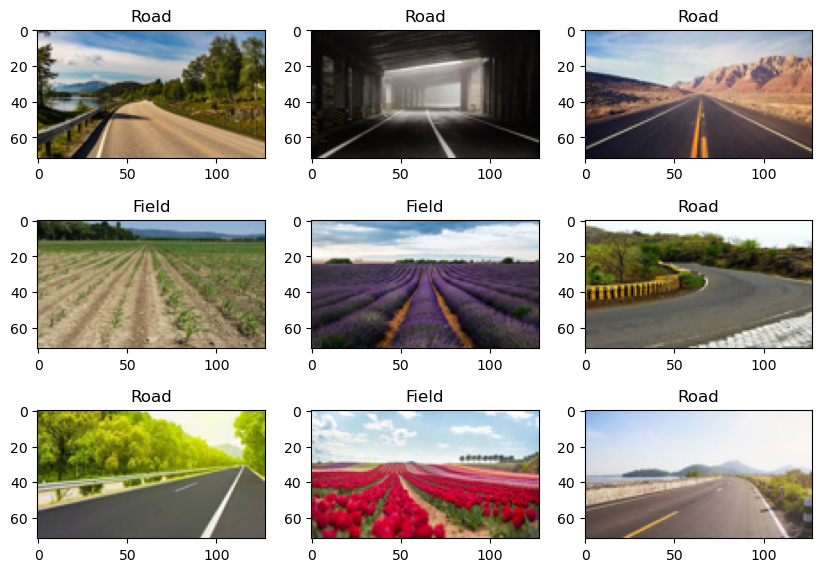

In [8]:
# show a sample of the dataset
plt.figure(figsize=(10,7))
plt.subplot(3,3,9)
for i in range(9):
    n = random.randint(0,100)
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[n])
    if y_train[n][1] == 1:
        plt.title("Road")
    else:
        plt.title("Field")

## Building  a Resnet50 classifier

In [9]:
# Parameters of Training
BATCH_SIZE = 8
EPOCHS =100
lr = 0.1

In [10]:
# good performance CNN
model = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(height, width, 3),
    pooling= None,
    classes=2,
    classifier_activation = "softmax",
)




# callback
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

### 1 Training with the original dataset

In [11]:
# cloning the model for the same initialized wieghts for every test
model_normal = tf.keras.models.clone_model(model)

#Compiling th model with all the metrics and loss function we want to use
model_normal.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [ tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'), 
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')],
                        loss=tf.keras.losses.CategoricalCrossentropy(),
            )

# Training metrics histor
hist_n = model_normal.fit(x_train,y_train,
                         batch_size=BATCH_SIZE,               
                         epochs=EPOCHS,
                         steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                         validation_data=(x_test,y_test),
                         callbacks= [lr_reduction],
                        )



# Testing the model on the dataset
model_normal.evaluate(x_test, y_test)


#save model
model_normal.save('./models/Resnet50_original_dataset')


Epoch 1/100
19/19 [==============================] - 10s 286ms/step - loss: 13.7996 - tp: 86.0000 - fp: 66.0000 - tn: 86.0000 - fn: 66.0000 - accuracy: 0.5658 - precision: 0.5658 - recall: 0.5658 - auc: 0.5757 - prc: 0.5559 - val_loss: 13085205.0000 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 2/100
19/19 [==============================] - 5s 253ms/step - loss: 4.5312 - tp: 91.0000 - fp: 54.0000 - tn: 91.0000 - fn: 54.0000 - accuracy: 0.6276 - precision: 0.6276 - recall: 0.6276 - auc: 0.6396 - prc: 0.6086 - val_loss: 583692.3750 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 3/100
19/19 [==============================] - 5s 239ms/step - loss: 6.0838 - tp: 92.0000 - fp: 53.0000 - tn: 92.0000 - fn: 53.0

19/19 [==============================] - 5s 238ms/step - loss: 0.6496 - tp: 123.0000 - fp: 22.0000 - tn: 123.0000 - fn: 22.0000 - accuracy: 0.8483 - precision: 0.8483 - recall: 0.8483 - auc: 0.8882 - prc: 0.8724 - val_loss: 0.8318 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5300 - val_prc: 0.6126 - lr: 0.1000
Epoch 21/100
19/19 [==============================] - 5s 247ms/step - loss: 0.6242 - tp: 124.0000 - fp: 28.0000 - tn: 124.0000 - fn: 28.0000 - accuracy: 0.8158 - precision: 0.8158 - recall: 0.8158 - auc: 0.8646 - prc: 0.8386 - val_loss: 0.7964 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5900 - val_prc: 0.6649 - lr: 0.0100
Epoch 22/100
19/19 [==============================] - 5s 246ms/step - loss: 0.4989 - tp: 126.0000 - fp: 19.0000 - tn: 126.0000 - fn: 19.0000 - accuracy: 0.

19/19 [==============================] - 5s 237ms/step - loss: 0.3136 - tp: 128.0000 - fp: 17.0000 - tn: 128.0000 - fn: 17.0000 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9423 - prc: 0.9393 - val_loss: 0.9832 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4800 - val_prc: 0.4685 - lr: 1.0000e-05
Epoch 40/100
19/19 [==============================] - 5s 237ms/step - loss: 0.3426 - tp: 128.0000 - fp: 17.0000 - tn: 128.0000 - fn: 17.0000 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - auc: 0.9215 - prc: 0.9177 - val_loss: 0.9960 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4800 - val_prc: 0.4685 - lr: 1.0000e-05
Epoch 41/100
19/19 [==============================] - 5s 246ms/step - loss: 0.3308 - tp: 131.0000 - fp: 21.0000 - tn: 131.0000 - fn: 21.0000 - accu

Epoch 58/100
19/19 [==============================] - 5s 243ms/step - loss: 0.3623 - tp: 124.0000 - fp: 21.0000 - tn: 124.0000 - fn: 21.0000 - accuracy: 0.8552 - precision: 0.8552 - recall: 0.8552 - auc: 0.9179 - prc: 0.9154 - val_loss: 1.0254 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4800 - val_prc: 0.4685 - lr: 1.0000e-06
Epoch 59/100
19/19 [==============================] - 5s 238ms/step - loss: 0.3446 - tp: 125.0000 - fp: 20.0000 - tn: 125.0000 - fn: 20.0000 - accuracy: 0.8621 - precision: 0.8621 - recall: 0.8621 - auc: 0.9274 - prc: 0.9269 - val_loss: 1.0318 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4800 - val_prc: 0.4685 - lr: 1.0000e-06
Epoch 60/100
19/19 [==============================] - 5s 237ms/step - loss: 0.3338 - tp: 123.0000 - fp: 22.0000 - tn: 123.0000 - fn: 2

Epoch 77/100
19/19 [==============================] - 5s 239ms/step - loss: 0.3197 - tp: 124.0000 - fp: 21.0000 - tn: 124.0000 - fn: 21.0000 - accuracy: 0.8552 - precision: 0.8552 - recall: 0.8552 - auc: 0.9414 - prc: 0.9404 - val_loss: 1.0314 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4800 - val_prc: 0.4685 - lr: 1.0000e-06
Epoch 78/100
19/19 [==============================] - 5s 239ms/step - loss: 0.2848 - tp: 129.0000 - fp: 16.0000 - tn: 129.0000 - fn: 16.0000 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897 - auc: 0.9561 - prc: 0.9554 - val_loss: 1.0254 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4800 - val_prc: 0.4685 - lr: 1.0000e-06
Epoch 79/100
19/19 [==============================] - 5s 239ms/step - loss: 0.3946 - tp: 116.0000 - fp: 29.0000 - tn: 116.0000 - fn: 2

Epoch 96/100
19/19 [==============================] - 5s 238ms/step - loss: 0.3488 - tp: 124.0000 - fp: 21.0000 - tn: 124.0000 - fn: 21.0000 - accuracy: 0.8552 - precision: 0.8552 - recall: 0.8552 - auc: 0.9275 - prc: 0.9196 - val_loss: 1.0361 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4800 - val_prc: 0.4685 - lr: 1.0000e-06
Epoch 97/100
19/19 [==============================] - 5s 237ms/step - loss: 0.3223 - tp: 125.0000 - fp: 20.0000 - tn: 125.0000 - fn: 20.0000 - accuracy: 0.8621 - precision: 0.8621 - recall: 0.8621 - auc: 0.9397 - prc: 0.9398 - val_loss: 1.0364 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4800 - val_prc: 0.4685 - lr: 1.0000e-06
Epoch 98/100
19/19 [==============================] - 4s 236ms/step - loss: 0.3837 - tp: 122.0000 - fp: 23.0000 - tn: 122.0000 - fn: 2

INFO:tensorflow:Assets written to: ./models/Resnet50_original_dataset\assets


INFO:tensorflow:Assets written to: ./models/Resnet50_original_dataset\assets


In [12]:
# summarize history for accuracy
def plot_train_graph(hist, figure_name):
    fig = plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(hist.history['precision'])
    plt.plot(hist.history['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    # summarize history for loss
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim([0,10])
    plt.grid()
    plt.show()


    fig.savefig(f"./figures/{figure_name}.pdf")

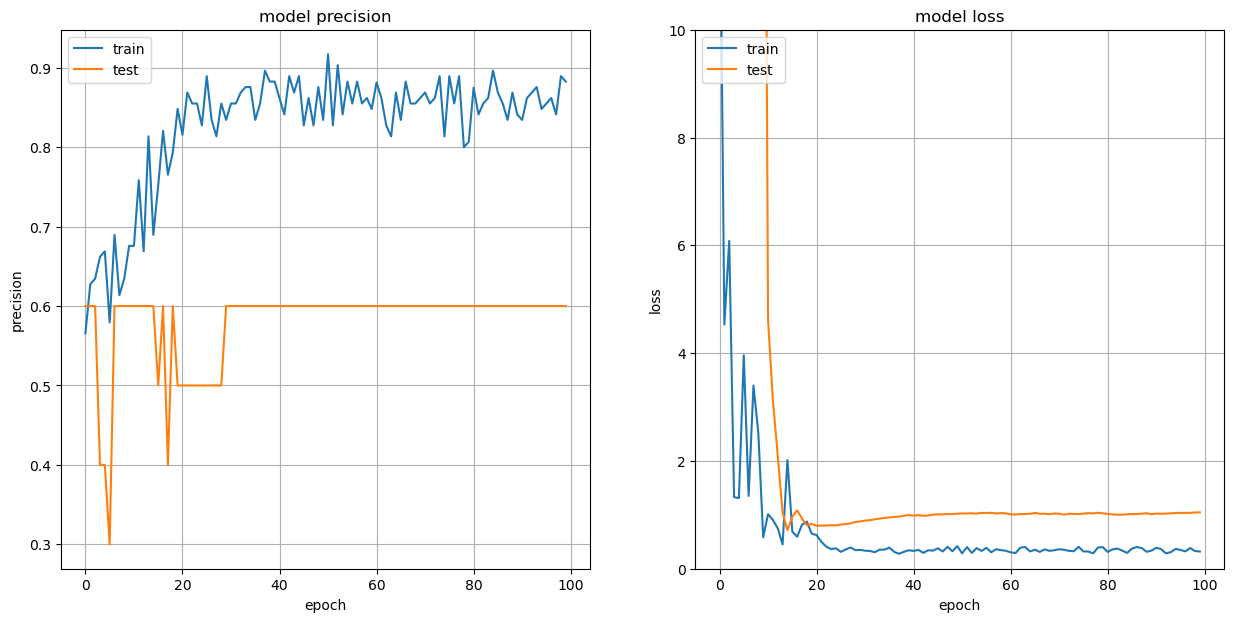

In [13]:
plot_train_graph(hist_n, "Resnet50_normal_dataset")

### 2 Training with the weighted classes

In [14]:
model_weighted = tf.keras.models.clone_model(model)

#Compiling th model with all the metrics and loss function we want to use
model_weighted.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [ tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'), 
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')],
                        loss=tf.keras.losses.CategoricalCrossentropy(),
            )

hist_w = model_weighted.fit(x_train,y_train,
                         batch_size=BATCH_SIZE,               
                         epochs=EPOCHS,
                         steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                         validation_data=(x_test,y_test),
                         callbacks= [lr_reduction],
                         class_weight=class_weight,
                        )



# Testing the model on the dataset
model_weighted.evaluate(x_test, y_test)



model_weighted.save('./models/Resnet50_weighted')

Epoch 1/100
19/19 [==============================] - 10s 287ms/step - loss: 21.5852 - tp: 73.0000 - fp: 79.0000 - tn: 73.0000 - fn: 79.0000 - accuracy: 0.4803 - precision: 0.4803 - recall: 0.4803 - auc: 0.4710 - prc: 0.4827 - val_loss: 428529344.0000 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4000 - val_prc: 0.4368 - lr: 0.1000
Epoch 2/100
19/19 [==============================] - 5s 253ms/step - loss: 5.3681 - tp: 78.0000 - fp: 67.0000 - tn: 78.0000 - fn: 67.0000 - accuracy: 0.5379 - precision: 0.5379 - recall: 0.5379 - auc: 0.5473 - prc: 0.5362 - val_loss: 638259.1875 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 3/100
19/19 [==============================] - 5s 245ms/step - loss: 3.2523 - tp: 66.0000 - fp: 79.0000 - tn: 66.0000 - fn: 79.

19/19 [==============================] - 5s 272ms/step - loss: 0.7740 - tp: 113.0000 - fp: 32.0000 - tn: 113.0000 - fn: 32.0000 - accuracy: 0.7793 - precision: 0.7793 - recall: 0.7793 - auc: 0.7620 - prc: 0.7271 - val_loss: 228.0032 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.4700 - val_prc: 0.4738 - lr: 0.0100
Epoch 21/100
19/19 [==============================] - 5s 288ms/step - loss: 0.7013 - tp: 115.0000 - fp: 37.0000 - tn: 115.0000 - fn: 37.0000 - accuracy: 0.7566 - precision: 0.7566 - recall: 0.7566 - auc: 0.7537 - prc: 0.7203 - val_loss: 79.9243 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.5400 - val_prc: 0.5221 - lr: 0.0100
Epoch 22/100
19/19 [==============================] - 5s 296ms/step - loss: 0.7340 - tp: 113.0000 - fp: 32.0000 - tn: 113.0000 - fn: 32.0000 - accuracy:

Epoch 39/100
19/19 [==============================] - 5s 284ms/step - loss: 0.7317 - tp: 111.0000 - fp: 34.0000 - tn: 111.0000 - fn: 34.0000 - accuracy: 0.7655 - precision: 0.7655 - recall: 0.7655 - auc: 0.7555 - prc: 0.7144 - val_loss: 11.8416 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.4000 - val_prc: 0.4236 - lr: 1.0000e-06
Epoch 40/100
19/19 [==============================] - 5s 281ms/step - loss: 0.6152 - tp: 115.0000 - fp: 30.0000 - tn: 115.0000 - fn: 30.0000 - accuracy: 0.7931 - precision: 0.7931 - recall: 0.7931 - auc: 0.8403 - prc: 0.8031 - val_loss: 11.3489 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3400 - val_prc: 0.3935 - lr: 1.0000e-06
Epoch 41/100
19/19 [==============================] - 6s 294ms/step - loss: 0.6415 - tp: 122.0000 - fp: 30.0000 - tn: 122.0000 - fn:

Epoch 58/100
19/19 [==============================] - 5s 286ms/step - loss: 0.7349 - tp: 107.0000 - fp: 38.0000 - tn: 107.0000 - fn: 38.0000 - accuracy: 0.7379 - precision: 0.7379 - recall: 0.7379 - auc: 0.7270 - prc: 0.6878 - val_loss: 12.6528 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.4200 - val_prc: 0.4330 - lr: 1.0000e-06
Epoch 59/100
19/19 [==============================] - 5s 283ms/step - loss: 0.7118 - tp: 107.0000 - fp: 38.0000 - tn: 107.0000 - fn: 38.0000 - accuracy: 0.7379 - precision: 0.7379 - recall: 0.7379 - auc: 0.7655 - prc: 0.7196 - val_loss: 12.7052 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3400 - val_prc: 0.3935 - lr: 1.0000e-06
Epoch 60/100
19/19 [==============================] - 5s 281ms/step - loss: 0.5991 - tp: 116.0000 - fp: 29.0000 - tn: 116.0000 - fn:

Epoch 77/100
19/19 [==============================] - 5s 279ms/step - loss: 0.6531 - tp: 112.0000 - fp: 33.0000 - tn: 112.0000 - fn: 33.0000 - accuracy: 0.7724 - precision: 0.7724 - recall: 0.7724 - auc: 0.7909 - prc: 0.7600 - val_loss: 12.0045 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.4200 - val_prc: 0.4330 - lr: 1.0000e-06
Epoch 78/100
19/19 [==============================] - 5s 280ms/step - loss: 0.6054 - tp: 119.0000 - fp: 26.0000 - tn: 119.0000 - fn: 26.0000 - accuracy: 0.8207 - precision: 0.8207 - recall: 0.8207 - auc: 0.8436 - prc: 0.8097 - val_loss: 10.9414 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3400 - val_prc: 0.3935 - lr: 1.0000e-06
Epoch 79/100
19/19 [==============================] - 5s 281ms/step - loss: 0.6050 - tp: 112.0000 - fp: 33.0000 - tn: 112.0000 - fn:

Epoch 96/100
19/19 [==============================] - 5s 283ms/step - loss: 0.6094 - tp: 112.0000 - fp: 33.0000 - tn: 112.0000 - fn: 33.0000 - accuracy: 0.7724 - precision: 0.7724 - recall: 0.7724 - auc: 0.8291 - prc: 0.8010 - val_loss: 12.7436 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3400 - val_prc: 0.3935 - lr: 1.0000e-06
Epoch 97/100
19/19 [==============================] - 5s 282ms/step - loss: 0.6254 - tp: 118.0000 - fp: 27.0000 - tn: 118.0000 - fn: 27.0000 - accuracy: 0.8138 - precision: 0.8138 - recall: 0.8138 - auc: 0.8133 - prc: 0.7835 - val_loss: 11.6463 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3600 - val_prc: 0.4023 - lr: 1.0000e-06
Epoch 98/100
19/19 [==============================] - 5s 284ms/step - loss: 0.5748 - tp: 111.0000 - fp: 34.0000 - tn: 111.0000 - fn:

INFO:tensorflow:Assets written to: ./models/Resnet50_weighted\assets


INFO:tensorflow:Assets written to: ./models/Resnet50_weighted\assets


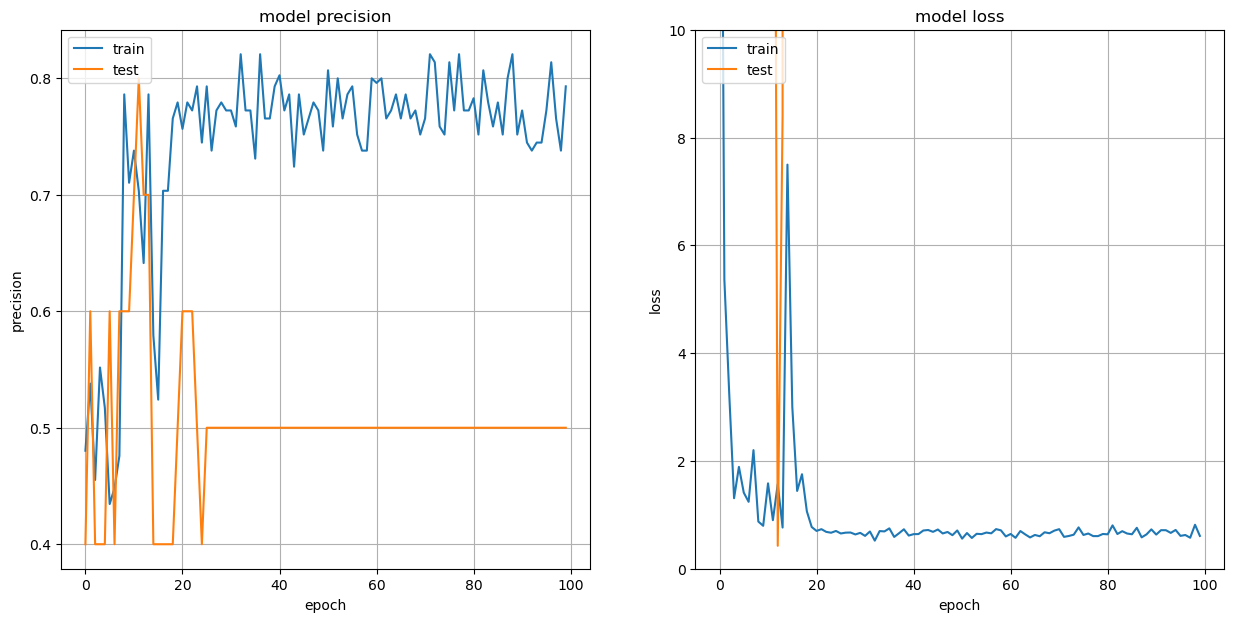

In [15]:
plot_train_graph(hist_w, "Resnet50_weighted_dataset")

### 3 Training with the subsampled dataset

In [16]:
model_sub = tf.keras.models.clone_model(model)

#Compiling th model with all the metrics and loss function we want to use
model_sub.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [ tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'), 
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')],
                        loss=tf.keras.losses.CategoricalCrossentropy(),
            )

hist_s = model_sub.fit(x_train_sub,y_train_sub,
                         batch_size=BATCH_SIZE,               
                         epochs=EPOCHS,
                         steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                         validation_data=(x_test,y_test),
                         callbacks= [lr_reduction],
                        )



# Testing the model on the dataset
model_sub.evaluate(x_test, y_test)



model_sub.save('./models/Resnet50_subsampled_data')

Epoch 1/100
19/19 [==============================] - 11s 348ms/step - loss: 19.0026 - tp: 88.0000 - fp: 62.0000 - tn: 88.0000 - fn: 62.0000 - accuracy: 0.5867 - precision: 0.5867 - recall: 0.5867 - auc: 0.5922 - prc: 0.5687 - val_loss: 337289888.0000 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 2/100
19/19 [==============================] - 6s 306ms/step - loss: 3.7652 - tp: 104.0000 - fp: 44.0000 - tn: 104.0000 - fn: 44.0000 - accuracy: 0.7027 - precision: 0.7027 - recall: 0.7027 - auc: 0.7295 - prc: 0.6923 - val_loss: 334697.2500 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 3/100
19/19 [==============================] - 6s 302ms/step - loss: 1.1952 - tp: 100.0000 - fp: 48.0000 - tn: 100.0000 - fn:

19/19 [==============================] - 5s 269ms/step - loss: 0.3992 - tp: 114.0000 - fp: 34.0000 - tn: 114.0000 - fn: 34.0000 - accuracy: 0.7703 - precision: 0.7703 - recall: 0.7703 - auc: 0.8923 - prc: 0.9000 - val_loss: 9.5236 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.5400 - val_prc: 0.5033 - lr: 0.0100
Epoch 21/100
19/19 [==============================] - 5s 273ms/step - loss: 0.4091 - tp: 116.0000 - fp: 32.0000 - tn: 116.0000 - fn: 32.0000 - accuracy: 0.7838 - precision: 0.7838 - recall: 0.7838 - auc: 0.8992 - prc: 0.9016 - val_loss: 8.0517 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.5400 - val_prc: 0.5033 - lr: 0.0100
Epoch 22/100
19/19 [==============================] - 5s 284ms/step - loss: 0.3418 - tp: 119.0000 - fp: 29.0000 - tn: 119.0000 - fn: 29.0000 - accuracy: 0.

Epoch 39/100
19/19 [==============================] - 5s 269ms/step - loss: 0.3488 - tp: 117.0000 - fp: 31.0000 - tn: 117.0000 - fn: 31.0000 - accuracy: 0.7905 - precision: 0.7905 - recall: 0.7905 - auc: 0.9179 - prc: 0.9244 - val_loss: 9.0052 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.5400 - val_prc: 0.5033 - lr: 1.0000e-06
Epoch 40/100
19/19 [==============================] - 5s 268ms/step - loss: 0.3832 - tp: 116.0000 - fp: 32.0000 - tn: 116.0000 - fn: 32.0000 - accuracy: 0.7838 - precision: 0.7838 - recall: 0.7838 - auc: 0.8958 - prc: 0.9028 - val_loss: 9.2320 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.5300 - val_prc: 0.4971 - lr: 1.0000e-06
Epoch 41/100
19/19 [==============================] - 5s 278ms/step - loss: 0.3565 - tp: 117.0000 - fp: 33.0000 - tn: 117.0000 - fn: 3

Epoch 58/100
17/19 [=========================>....] - ETA: 0s - loss: 0.3689 - tp: 107.0000 - fp: 25.0000 - tn: 107.0000 - fn: 25.0000 - accuracy: 0.8106 - precision: 0.8106 - recall: 0.8106 - auc: 0.9038 - prc: 0.9105WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1900 batches). You may need to use the repeat() function when building your dataset.


1/1 [==============================] - 0s 95ms/step - loss: 8.3366 - tp: 6.0000 - fp: 4.0000 - tn: 6.0000 - fn: 4.0000 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.6000 - auc: 0.5400 - prc: 0.5033


INFO:tensorflow:Assets written to: ./models/Resnet50_subsampled_data\assets


INFO:tensorflow:Assets written to: ./models/Resnet50_subsampled_data\assets


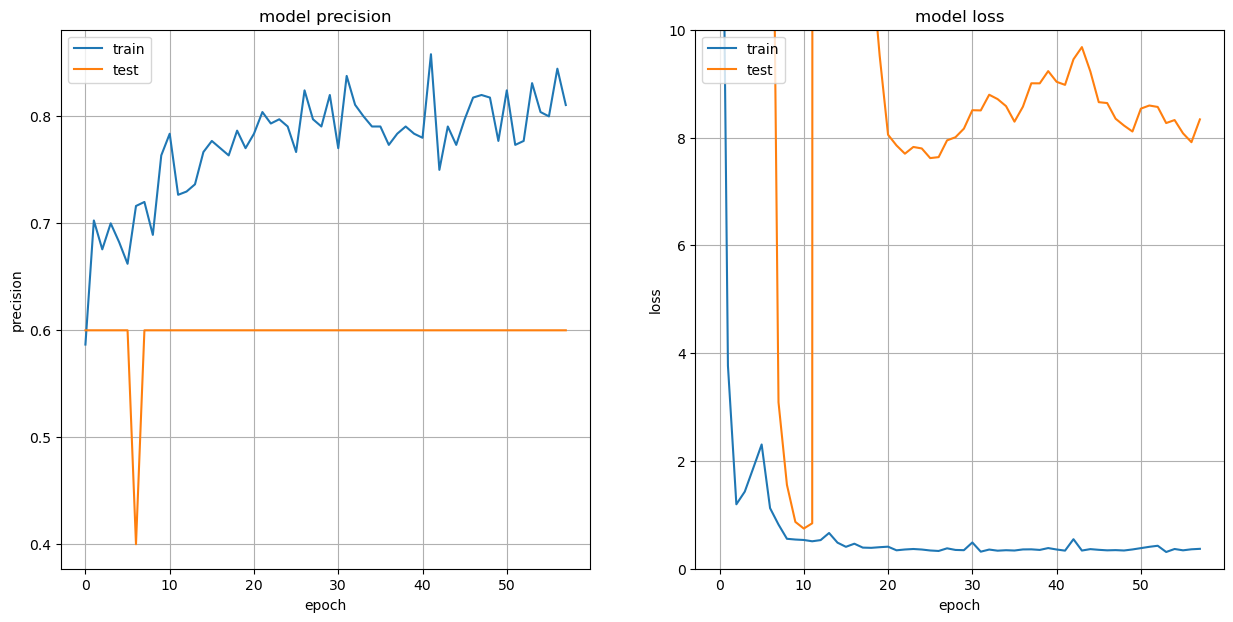

In [17]:
plot_train_graph(hist_s, "Resnet50_sub_dataset")

### 4 Training with the Oversampled dataset

In [18]:
model_over = tf.keras.models.clone_model(model)

#Compiling th model with all the metrics and loss function we want to use
model_over.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [ tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'), 
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')],
                        loss=tf.keras.losses.CategoricalCrossentropy(),
            )

hist_o = model_over.fit(x_train_over,y_train_over,
                         batch_size=BATCH_SIZE,               
                         epochs=EPOCHS,
                         steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
                         validation_data=(x_test,y_test),
                         callbacks= [lr_reduction],
                        )



# Testing the model on the dataset
model_over.evaluate(x_test, y_test)

model_over.save('./models/Resnet50_oversampled_data')

Epoch 1/100
19/19 [==============================] - 11s 348ms/step - loss: 18.7554 - tp: 79.0000 - fp: 73.0000 - tn: 79.0000 - fn: 73.0000 - accuracy: 0.5197 - precision: 0.5197 - recall: 0.5197 - auc: 0.5390 - prc: 0.5300 - val_loss: 89277752.0000 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4000 - val_prc: 0.4368 - lr: 0.1000
Epoch 2/100
19/19 [==============================] - 6s 306ms/step - loss: 3.0616 - tp: 86.0000 - fp: 62.0000 - tn: 86.0000 - fn: 62.0000 - accuracy: 0.5811 - precision: 0.5811 - recall: 0.5811 - auc: 0.5998 - prc: 0.5768 - val_loss: 94623.6094 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 3/100
19/19 [==============================] - 6s 306ms/step - loss: 3.4942 - tp: 78.0000 - fp: 70.0000 - tn: 78.0000 - fn: 70.00

19/19 [==============================] - 6s 299ms/step - loss: 0.4548 - tp: 117.0000 - fp: 31.0000 - tn: 117.0000 - fn: 31.0000 - accuracy: 0.7905 - precision: 0.7905 - recall: 0.7905 - auc: 0.8713 - prc: 0.8651 - val_loss: 1.7711 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.3915 - lr: 1.0000e-03
Epoch 21/100
19/19 [==============================] - 6s 297ms/step - loss: 0.2808 - tp: 131.0000 - fp: 17.0000 - tn: 131.0000 - fn: 17.0000 - accuracy: 0.8851 - precision: 0.8851 - recall: 0.8851 - auc: 0.9564 - prc: 0.9581 - val_loss: 1.7650 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.3915 - lr: 1.0000e-04
Epoch 22/100
19/19 [==============================] - 6s 309ms/step - loss: 0.3865 - tp: 124.0000 - fp: 28.0000 - tn: 124.0000 - fn: 28.0000 - accu

Epoch 39/100
19/19 [==============================] - 6s 298ms/step - loss: 0.3465 - tp: 127.0000 - fp: 21.0000 - tn: 127.0000 - fn: 21.0000 - accuracy: 0.8581 - precision: 0.8581 - recall: 0.8581 - auc: 0.9258 - prc: 0.9272 - val_loss: 2.0196 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3900 - val_prc: 0.4179 - lr: 1.0000e-06
Epoch 40/100
19/19 [==============================] - 6s 298ms/step - loss: 0.4259 - tp: 124.0000 - fp: 24.0000 - tn: 124.0000 - fn: 24.0000 - accuracy: 0.8378 - precision: 0.8378 - recall: 0.8378 - auc: 0.8867 - prc: 0.8799 - val_loss: 2.0742 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3900 - val_prc: 0.4179 - lr: 1.0000e-06
Epoch 41/100
19/19 [==============================] - 6s 307ms/step - loss: 0.3486 - tp: 129.0000 - fp: 23.0000 - tn: 129.0000 - fn: 2

Epoch 58/100
19/19 [==============================] - 6s 318ms/step - loss: 0.4184 - tp: 124.0000 - fp: 24.0000 - tn: 124.0000 - fn: 24.0000 - accuracy: 0.8378 - precision: 0.8378 - recall: 0.8378 - auc: 0.8910 - prc: 0.8752 - val_loss: 2.1703 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3900 - val_prc: 0.4179 - lr: 1.0000e-06
Epoch 59/100
19/19 [==============================] - 6s 323ms/step - loss: 0.3590 - tp: 125.0000 - fp: 23.0000 - tn: 125.0000 - fn: 23.0000 - accuracy: 0.8446 - precision: 0.8446 - recall: 0.8446 - auc: 0.9190 - prc: 0.9212 - val_loss: 2.0859 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3900 - val_prc: 0.4179 - lr: 1.0000e-06
Epoch 60/100
19/19 [==============================] - 6s 343ms/step - loss: 0.3592 - tp: 129.0000 - fp: 23.0000 - tn: 129.0000 - fn: 2

Epoch 77/100
19/19 [==============================] - 6s 323ms/step - loss: 0.3474 - tp: 127.0000 - fp: 21.0000 - tn: 127.0000 - fn: 21.0000 - accuracy: 0.8581 - precision: 0.8581 - recall: 0.8581 - auc: 0.9270 - prc: 0.9233 - val_loss: 2.0898 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3900 - val_prc: 0.4179 - lr: 1.0000e-06
Epoch 78/100
19/19 [==============================] - 6s 334ms/step - loss: 0.3133 - tp: 132.0000 - fp: 20.0000 - tn: 132.0000 - fn: 20.0000 - accuracy: 0.8684 - precision: 0.8684 - recall: 0.8684 - auc: 0.9410 - prc: 0.9379 - val_loss: 2.0090 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3900 - val_prc: 0.4179 - lr: 1.0000e-06
Epoch 79/100
19/19 [==============================] - 6s 319ms/step - loss: 0.4031 - tp: 118.0000 - fp: 30.0000 - tn: 118.0000 - fn: 3

Epoch 96/100
19/19 [==============================] - 6s 304ms/step - loss: 0.3103 - tp: 130.0000 - fp: 18.0000 - tn: 130.0000 - fn: 18.0000 - accuracy: 0.8784 - precision: 0.8784 - recall: 0.8784 - auc: 0.9439 - prc: 0.9436 - val_loss: 2.0006 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3900 - val_prc: 0.4179 - lr: 1.0000e-06
Epoch 97/100
19/19 [==============================] - 6s 308ms/step - loss: 0.3594 - tp: 126.0000 - fp: 26.0000 - tn: 126.0000 - fn: 26.0000 - accuracy: 0.8289 - precision: 0.8289 - recall: 0.8289 - auc: 0.9227 - prc: 0.9172 - val_loss: 2.0046 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.3900 - val_prc: 0.4179 - lr: 1.0000e-06
Epoch 98/100
19/19 [==============================] - 6s 314ms/step - loss: 0.3324 - tp: 131.0000 - fp: 17.0000 - tn: 131.0000 - fn: 1

INFO:tensorflow:Assets written to: ./models/Resnet50_oversampled_data\assets


INFO:tensorflow:Assets written to: ./models/Resnet50_oversampled_data\assets


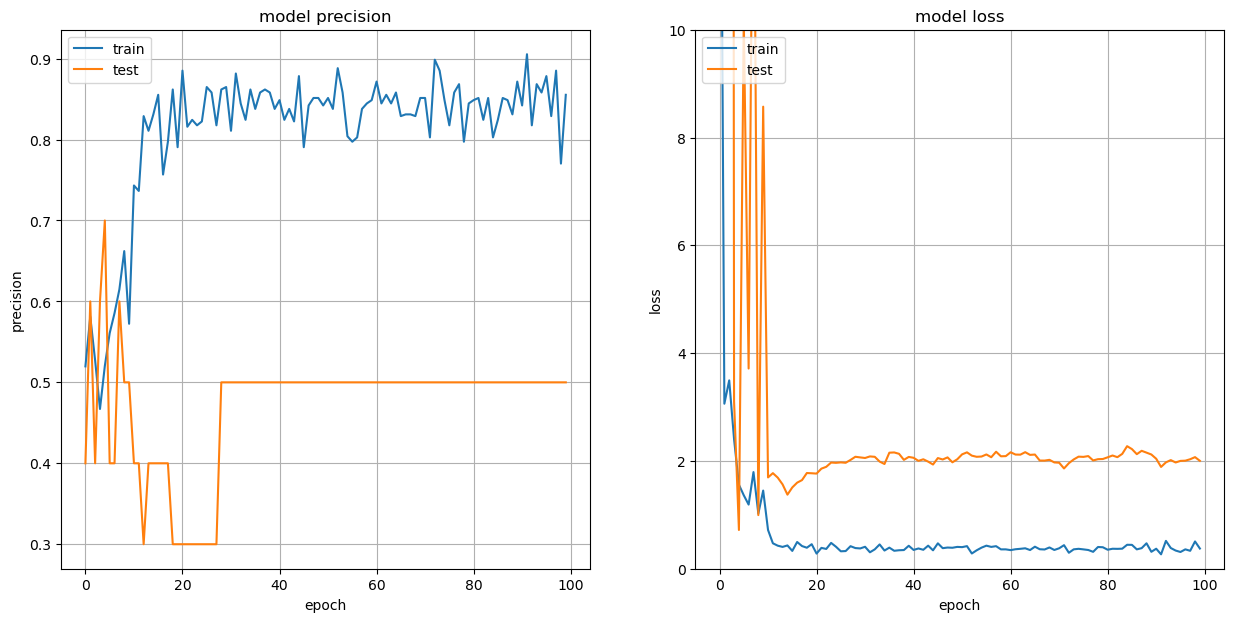

In [19]:
plot_train_graph(hist_o, "Resnet50_over_dataset")

In [20]:
# do a visual compareson of the differents training curves
hist_dic = {"normal": hist_n,
            "weighted": hist_w,
            "subsampled": hist_s,
            "oversampled": hist_o,        
}

# plot function fo comparing the curves
def compare_hist(list_hist, figure_name):
    fig = plt.figure(figsize=(15,10))
    for key in list_hist:
        ax1 = plt.subplot(221)
        plt.plot(list_hist[key].history['precision'], label= f'train_{key}')
        plt.title('model precision')
        plt.ylabel('precision')
        plt.xlabel('epoch')
        plt.legend( loc='upper left')

       
        # summarize history for precision
        ax2 = plt.subplot(223)
        plt.plot(list_hist[key].history['val_precision'], label= f'test_{key}') 
        plt.title('model validation prec')
        plt.ylabel('precision')
        plt.xlabel('epoch')
        plt.legend(loc='upper left')
    
        
        
        # summarize history for loss
        ax3 = plt.subplot(222)
        plt.plot(list_hist[key].history['loss'], label =f'train_{key}')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend( loc='upper right')
        plt.ylim([0,30])
      
        
        
         # summarize history for loss
        ax4 = plt.subplot(224)
        plt.plot(list_hist[key].history['val_loss'], label= f'test_{key}')
        plt.title('model val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend( loc='upper right')
        plt.ylim([0,1000])

        
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    plt.show()
    fig.savefig(f"./figures/{figure_name}.pdf")

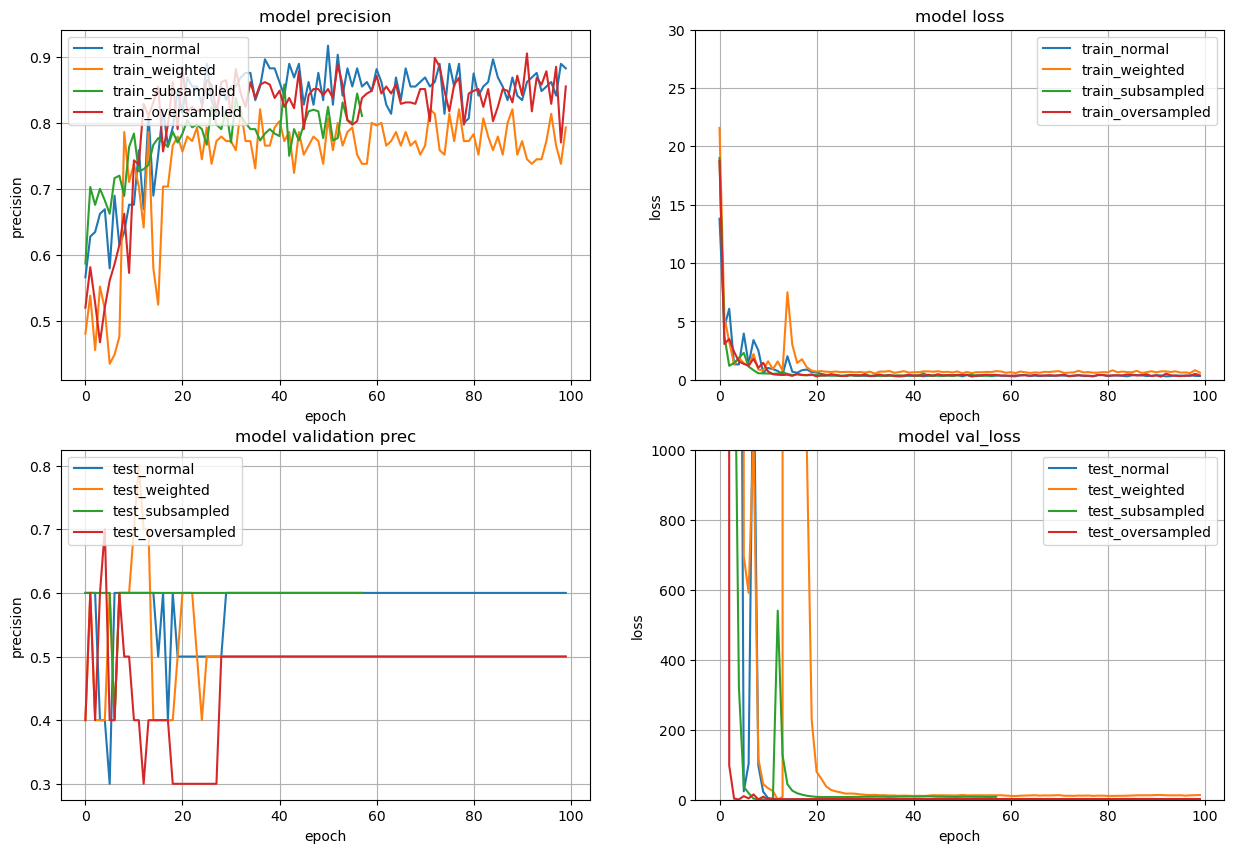

In [21]:
compare_hist(hist_dic, "training compare Resnet50")

## Training the models with Image data generator

### 1 - Original dataset trained with datagen

In [22]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

model_normal_datagen = tf.keras.models.clone_model(model)

datagen.fit(x_train)


#Compiling th model with all the metrics and loss function we want to use
model_normal_datagen.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [ tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'), 
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')],
                        loss=tf.keras.losses.CategoricalCrossentropy(),
            )



hist_n_datagen= model_normal_datagen.fit(datagen.flow(x_train,y_train,
                                       batch_size=BATCH_SIZE, 
                                       seed=27,
                                       shuffle=False),
                    epochs=EPOCHS,
                    validation_data=(x_test,y_test),
                    callbacks= [lr_reduction],
                    )
# Testing the model on the dataset
model_normal_datagen.evaluate(x_test, y_test)

model_normal_datagen.save('./models/Resnet50_original_datagen')

Epoch 1/100
20/20 [==============================] - 13s 413ms/step - loss: 19.5894 - tp: 93.0000 - fp: 60.0000 - tn: 93.0000 - fn: 60.0000 - accuracy: 0.6078 - precision: 0.6078 - recall: 0.6078 - auc: 0.6252 - prc: 0.5964 - val_loss: 104779496.0000 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4000 - val_prc: 0.4368 - lr: 0.1000
Epoch 2/100
20/20 [==============================] - 7s 374ms/step - loss: 9.6391 - tp: 80.0000 - fp: 73.0000 - tn: 80.0000 - fn: 73.0000 - accuracy: 0.5229 - precision: 0.5229 - recall: 0.5229 - auc: 0.4885 - prc: 0.4899 - val_loss: 2000656.6250 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4000 - val_prc: 0.4368 - lr: 0.1000
Epoch 3/100
20/20 [==============================] - 7s 371ms/step - loss: 1.0251 - tp: 114.0000 - fp: 39.0000 - tn: 114.0000 - fn: 

20/20 [==============================] - 7s 369ms/step - loss: 0.5179 - tp: 119.0000 - fp: 34.0000 - tn: 119.0000 - fn: 34.0000 - accuracy: 0.7778 - precision: 0.7778 - recall: 0.7778 - auc: 0.8231 - prc: 0.7964 - val_loss: 26.5000 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3900 - val_prc: 0.4291 - lr: 1.0000e-03
Epoch 21/100
20/20 [==============================] - 7s 370ms/step - loss: 0.5234 - tp: 115.0000 - fp: 38.0000 - tn: 115.0000 - fn: 38.0000 - accuracy: 0.7516 - precision: 0.7516 - recall: 0.7516 - auc: 0.8495 - prc: 0.8293 - val_loss: 26.0264 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3900 - val_prc: 0.4291 - lr: 1.0000e-03
Epoch 22/100
20/20 [==============================] - 7s 364ms/step - loss: 0.5147 - tp: 117.0000 - fp: 36.0000 - tn: 117.0000 - fn: 36.0000 - ac

Epoch 39/100
20/20 [==============================] - 7s 363ms/step - loss: 0.4867 - tp: 119.0000 - fp: 34.0000 - tn: 119.0000 - fn: 34.0000 - accuracy: 0.7778 - precision: 0.7778 - recall: 0.7778 - auc: 0.8603 - prc: 0.8464 - val_loss: 16.1020 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3400 - val_prc: 0.3996 - lr: 1.0000e-05
Epoch 40/100
20/20 [==============================] - 7s 361ms/step - loss: 0.4951 - tp: 120.0000 - fp: 33.0000 - tn: 120.0000 - fn: 33.0000 - accuracy: 0.7843 - precision: 0.7843 - recall: 0.7843 - auc: 0.8626 - prc: 0.8503 - val_loss: 15.8695 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3400 - val_prc: 0.3996 - lr: 1.0000e-05
Epoch 41/100
20/20 [==============================] - 7s 363ms/step - loss: 0.4804 - tp: 122.0000 - fp: 31.0000 - tn: 122.0000 - fn:

Epoch 58/100
20/20 [==============================] - 7s 361ms/step - loss: 0.4963 - tp: 119.0000 - fp: 34.0000 - tn: 119.0000 - fn: 34.0000 - accuracy: 0.7778 - precision: 0.7778 - recall: 0.7778 - auc: 0.8558 - prc: 0.8395 - val_loss: 16.9677 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3400 - val_prc: 0.3996 - lr: 1.0000e-06
Epoch 59/100
20/20 [==============================] - 7s 360ms/step - loss: 0.4775 - tp: 120.0000 - fp: 33.0000 - tn: 120.0000 - fn: 33.0000 - accuracy: 0.7843 - precision: 0.7843 - recall: 0.7843 - auc: 0.8680 - prc: 0.8621 - val_loss: 17.4599 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3900 - val_prc: 0.4291 - lr: 1.0000e-06
Epoch 60/100
20/20 [==============================] - 7s 360ms/step - loss: 0.4936 - tp: 122.0000 - fp: 31.0000 - tn: 122.0000 - fn:

Epoch 77/100
20/20 [==============================] - 7s 369ms/step - loss: 0.5151 - tp: 119.0000 - fp: 34.0000 - tn: 119.0000 - fn: 34.0000 - accuracy: 0.7778 - precision: 0.7778 - recall: 0.7778 - auc: 0.8567 - prc: 0.8212 - val_loss: 17.2184 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3900 - val_prc: 0.4291 - lr: 1.0000e-06
Epoch 78/100
20/20 [==============================] - 8s 374ms/step - loss: 0.5425 - tp: 115.0000 - fp: 38.0000 - tn: 115.0000 - fn: 38.0000 - accuracy: 0.7516 - precision: 0.7516 - recall: 0.7516 - auc: 0.8269 - prc: 0.7858 - val_loss: 16.6351 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3400 - val_prc: 0.3996 - lr: 1.0000e-06
Epoch 79/100
20/20 [==============================] - 7s 366ms/step - loss: 0.4876 - tp: 118.0000 - fp: 35.0000 - tn: 118.0000 - fn:

Epoch 96/100
20/20 [==============================] - 7s 364ms/step - loss: 0.5062 - tp: 120.0000 - fp: 33.0000 - tn: 120.0000 - fn: 33.0000 - accuracy: 0.7843 - precision: 0.7843 - recall: 0.7843 - auc: 0.8576 - prc: 0.8397 - val_loss: 17.6929 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3900 - val_prc: 0.4291 - lr: 1.0000e-06
Epoch 97/100
20/20 [==============================] - 7s 366ms/step - loss: 0.5033 - tp: 119.0000 - fp: 34.0000 - tn: 119.0000 - fn: 34.0000 - accuracy: 0.7778 - precision: 0.7778 - recall: 0.7778 - auc: 0.8670 - prc: 0.8601 - val_loss: 17.4367 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.3900 - val_prc: 0.4291 - lr: 1.0000e-06
Epoch 98/100
20/20 [==============================] - 7s 371ms/step - loss: 0.5121 - tp: 119.0000 - fp: 34.0000 - tn: 119.0000 - fn:

INFO:tensorflow:Assets written to: ./models/Resnet50_original_datagen\assets


INFO:tensorflow:Assets written to: ./models/Resnet50_original_datagen\assets


### 2 - Original dataset with weighted loss function

In [23]:
model_weighted_datagen = tf.keras.models.clone_model(model)


#Compiling th model with all the metrics and loss function we want to use
model_weighted_datagen.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [ tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'), 
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')],
                        loss=tf.keras.losses.CategoricalCrossentropy(),
            )


hist_w_datagen= model_weighted_datagen.fit(datagen.flow(x_train,y_train,
                                       batch_size=BATCH_SIZE, 
                                       seed=27,
                                       shuffle=False),
                    epochs=EPOCHS,
                    validation_data=(x_test,y_test),
                    callbacks= [lr_reduction],
                    class_weight=class_weight,
                    )
# Testing the model on the dataset
model_weighted_datagen.evaluate(x_test, y_test)

model_weighted_datagen.save('./models/Resnet50_weighted_datagen')

Epoch 1/100
20/20 [==============================] - 12s 402ms/step - loss: 25.5306 - tp: 79.0000 - fp: 74.0000 - tn: 79.0000 - fn: 74.0000 - accuracy: 0.5163 - precision: 0.5163 - recall: 0.5163 - auc: 0.4715 - prc: 0.4751 - val_loss: 343912906752.0000 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 2/100
20/20 [==============================] - 7s 372ms/step - loss: 6.1972 - tp: 84.0000 - fp: 69.0000 - tn: 84.0000 - fn: 69.0000 - accuracy: 0.5490 - precision: 0.5490 - recall: 0.5490 - auc: 0.5411 - prc: 0.5280 - val_loss: 490364.8125 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 3/100
20/20 [==============================] - 8s 378ms/step - loss: 15.8496 - tp: 56.0000 - fp: 97.0000 - tn: 56.0000 - fn:

20/20 [==============================] - 8s 410ms/step - loss: 0.9603 - tp: 90.0000 - fp: 63.0000 - tn: 90.0000 - fn: 63.0000 - accuracy: 0.5882 - precision: 0.5882 - recall: 0.5882 - auc: 0.5252 - prc: 0.5003 - val_loss: 8.9434 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 5.0000 - val_fn: 5.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.4700 - val_prc: 0.4738 - lr: 0.0100
Epoch 21/100
20/20 [==============================] - 8s 392ms/step - loss: 0.8293 - tp: 101.0000 - fp: 52.0000 - tn: 101.0000 - fn: 52.0000 - accuracy: 0.6601 - precision: 0.6601 - recall: 0.6601 - auc: 0.6695 - prc: 0.6349 - val_loss: 65.2030 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4000 - val_prc: 0.4368 - lr: 0.0100
Epoch 22/100
20/20 [==============================] - 8s 393ms/step - loss: 0.7617 - tp: 108.0000 - fp: 45.0000 - tn: 108.0000 - fn: 45.0000 - accuracy: 0.7

Epoch 39/100
20/20 [==============================] - 8s 391ms/step - loss: 0.7631 - tp: 93.0000 - fp: 60.0000 - tn: 93.0000 - fn: 60.0000 - accuracy: 0.6078 - precision: 0.6078 - recall: 0.6078 - auc: 0.5924 - prc: 0.5532 - val_loss: 31.6475 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.4004 - lr: 1.0000e-06
Epoch 40/100
20/20 [==============================] - 8s 395ms/step - loss: 0.7060 - tp: 111.0000 - fp: 42.0000 - tn: 111.0000 - fn: 42.0000 - accuracy: 0.7255 - precision: 0.7255 - recall: 0.7255 - auc: 0.7385 - prc: 0.6832 - val_loss: 29.3411 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.4004 - lr: 1.0000e-06
Epoch 41/100
20/20 [==============================] - 8s 392ms/step - loss: 0.8543 - tp: 95.0000 - fp: 58.0000 - tn: 95.0000 - fn: 58.

Epoch 58/100
20/20 [==============================] - 8s 391ms/step - loss: 0.7984 - tp: 97.0000 - fp: 56.0000 - tn: 97.0000 - fn: 56.0000 - accuracy: 0.6340 - precision: 0.6340 - recall: 0.6340 - auc: 0.5718 - prc: 0.5311 - val_loss: 24.1599 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.4004 - lr: 1.0000e-06
Epoch 59/100
20/20 [==============================] - 8s 392ms/step - loss: 0.7626 - tp: 104.0000 - fp: 49.0000 - tn: 104.0000 - fn: 49.0000 - accuracy: 0.6797 - precision: 0.6797 - recall: 0.6797 - auc: 0.6725 - prc: 0.6236 - val_loss: 24.7949 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.4004 - lr: 1.0000e-06
Epoch 60/100
20/20 [==============================] - 8s 394ms/step - loss: 0.7639 - tp: 102.0000 - fp: 51.0000 - tn: 102.0000 - fn: 5

Epoch 77/100
20/20 [==============================] - 8s 393ms/step - loss: 0.7611 - tp: 105.0000 - fp: 48.0000 - tn: 105.0000 - fn: 48.0000 - accuracy: 0.6863 - precision: 0.6863 - recall: 0.6863 - auc: 0.6904 - prc: 0.6331 - val_loss: 30.3562 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.4004 - lr: 1.0000e-06
Epoch 78/100
20/20 [==============================] - 8s 392ms/step - loss: 0.7031 - tp: 99.0000 - fp: 54.0000 - tn: 99.0000 - fn: 54.0000 - accuracy: 0.6471 - precision: 0.6471 - recall: 0.6471 - auc: 0.6424 - prc: 0.6066 - val_loss: 30.8429 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.4004 - lr: 1.0000e-06
Epoch 79/100
20/20 [==============================] - 8s 392ms/step - loss: 0.6752 - tp: 116.0000 - fp: 37.0000 - tn: 116.0000 - fn: 3

Epoch 96/100
20/20 [==============================] - 8s 391ms/step - loss: 0.7239 - tp: 110.0000 - fp: 43.0000 - tn: 110.0000 - fn: 43.0000 - accuracy: 0.7190 - precision: 0.7190 - recall: 0.7190 - auc: 0.6971 - prc: 0.6470 - val_loss: 28.2989 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.4004 - lr: 1.0000e-06
Epoch 97/100
20/20 [==============================] - 8s 390ms/step - loss: 0.7340 - tp: 99.0000 - fp: 54.0000 - tn: 99.0000 - fn: 54.0000 - accuracy: 0.6471 - precision: 0.6471 - recall: 0.6471 - auc: 0.6149 - prc: 0.5790 - val_loss: 29.1404 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 3.0000 - val_fn: 7.0000 - val_accuracy: 0.3000 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.3300 - val_prc: 0.4004 - lr: 1.0000e-06
Epoch 98/100
20/20 [==============================] - 8s 390ms/step - loss: 0.7882 - tp: 105.0000 - fp: 48.0000 - tn: 105.0000 - fn: 4

INFO:tensorflow:Assets written to: ./models/Resnet50_weighted_datagen\assets


INFO:tensorflow:Assets written to: ./models/Resnet50_weighted_datagen\assets


### 3 - Subsampled dataset trained with datagen

In [24]:
model_sub_datagen = tf.keras.models.clone_model(model)


#Compiling th model with all the metrics and loss function we want to use
model_sub_datagen.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [ tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'), 
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')],
                        loss=tf.keras.losses.CategoricalCrossentropy(),
            )

datagen.fit(x_train_sub)

hist_s_datagen= model_sub_datagen.fit(datagen.flow(x_train_sub,y_train_sub,
                                       batch_size=BATCH_SIZE, 
                                       seed=27,
                                       shuffle=False),
                    epochs=EPOCHS,
                    validation_data=(x_test,y_test),
                    callbacks= [lr_reduction],
                    )
# Testing the model on the dataset
model_sub_datagen.evaluate(x_test, y_test)


model_sub_datagen.save('./models/Resnet50_sub_datagen')

Epoch 1/100
11/11 [==============================] - 10s 490ms/step - loss: 30.3751 - tp: 52.0000 - fp: 34.0000 - tn: 52.0000 - fn: 34.0000 - accuracy: 0.6047 - precision: 0.6047 - recall: 0.6047 - auc: 0.6485 - prc: 0.6187 - val_loss: 14755165110272.0000 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 2/100
11/11 [==============================] - 4s 408ms/step - loss: 7.7016 - tp: 48.0000 - fp: 38.0000 - tn: 48.0000 - fn: 38.0000 - accuracy: 0.5581 - precision: 0.5581 - recall: 0.5581 - auc: 0.5496 - prc: 0.5338 - val_loss: 5324733440.0000 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6000 - val_prc: 0.5755 - lr: 0.1000
Epoch 3/100
11/11 [==============================] - 4s 407ms/step - loss: 2.6952 - tp: 61.0000 - fp: 25.0000 - tn: 61.0000 

11/11 [==============================] - 4s 406ms/step - loss: 1.0640 - tp: 63.0000 - fp: 23.0000 - tn: 63.0000 - fn: 23.0000 - accuracy: 0.7326 - precision: 0.7326 - recall: 0.7326 - auc: 0.7430 - prc: 0.7080 - val_loss: 0.7574 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.7000 - val_prc: 0.7331 - lr: 0.1000
Epoch 21/100
11/11 [==============================] - 4s 415ms/step - loss: 1.2649 - tp: 60.0000 - fp: 26.0000 - tn: 60.0000 - fn: 26.0000 - accuracy: 0.6977 - precision: 0.6977 - recall: 0.6977 - auc: 0.6985 - prc: 0.6728 - val_loss: 0.7352 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4900 - val_prc: 0.4963 - lr: 0.1000
Epoch 22/100
11/11 [==============================] - 4s 404ms/step - loss: 0.8718 - tp: 57.0000 - fp: 29.0000 - tn: 57.0000 - fn: 29.0000 - accuracy: 0.6628 -

11/11 [==============================] - 4s 415ms/step - loss: 0.4467 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 0.7791 - precision: 0.7791 - recall: 0.7791 - auc: 0.8709 - prc: 0.8767 - val_loss: 0.6832 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.7000 - val_prc: 0.7380 - lr: 1.0000e-05
Epoch 40/100
11/11 [==============================] - 4s 414ms/step - loss: 0.5052 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 0.7791 - precision: 0.7791 - recall: 0.7791 - auc: 0.8537 - prc: 0.8477 - val_loss: 0.6836 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6600 - val_prc: 0.7106 - lr: 1.0000e-05
Epoch 41/100
11/11 [==============================] - 4s 408ms/step - loss: 0.5011 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 

11/11 [==============================] - 5s 421ms/step - loss: 0.4743 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 0.7791 - precision: 0.7791 - recall: 0.7791 - auc: 0.8414 - prc: 0.8448 - val_loss: 0.6907 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.7000 - val_prc: 0.7380 - lr: 1.0000e-06
Epoch 59/100
11/11 [==============================] - 5s 422ms/step - loss: 0.4608 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 0.7791 - precision: 0.7791 - recall: 0.7791 - auc: 0.8651 - prc: 0.8664 - val_loss: 0.6916 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.7000 - val_prc: 0.7380 - lr: 1.0000e-06
Epoch 60/100
11/11 [==============================] - 5s 419ms/step - loss: 0.4572 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 

11/11 [==============================] - 4s 406ms/step - loss: 0.4946 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 0.7791 - precision: 0.7791 - recall: 0.7791 - auc: 0.8488 - prc: 0.8443 - val_loss: 0.6951 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.7000 - val_prc: 0.7408 - lr: 1.0000e-06
Epoch 78/100
11/11 [==============================] - 4s 402ms/step - loss: 0.4881 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 0.7791 - precision: 0.7791 - recall: 0.7791 - auc: 0.8391 - prc: 0.8403 - val_loss: 0.6945 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.7000 - val_prc: 0.7380 - lr: 1.0000e-06
Epoch 79/100
11/11 [==============================] - 4s 403ms/step - loss: 0.4579 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 

11/11 [==============================] - 4s 403ms/step - loss: 0.4714 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 0.7791 - precision: 0.7791 - recall: 0.7791 - auc: 0.8513 - prc: 0.8566 - val_loss: 0.6895 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.6800 - val_prc: 0.7210 - lr: 1.0000e-06
Epoch 97/100
11/11 [==============================] - 5s 408ms/step - loss: 0.4559 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 0.7791 - precision: 0.7791 - recall: 0.7791 - auc: 0.8693 - prc: 0.8719 - val_loss: 0.6912 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.7000 - val_prc: 0.7380 - lr: 1.0000e-06
Epoch 98/100
11/11 [==============================] - 4s 407ms/step - loss: 0.4884 - tp: 67.0000 - fp: 19.0000 - tn: 67.0000 - fn: 19.0000 - accuracy: 

INFO:tensorflow:Assets written to: ./models/Resnet50_sub_datagen\assets


INFO:tensorflow:Assets written to: ./models/Resnet50_sub_datagen\assets


### 4 - Oversampled dataset trained with datagen

In [25]:
model_over_datagen = tf.keras.models.clone_model(model)


#Compiling th model with all the metrics and loss function we want to use
model_over_datagen.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [ tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'), 
                        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.AUC(name='prc', curve='PR')],
                        loss=tf.keras.losses.CategoricalCrossentropy(),
            )

datagen.fit(x_train_over)

hist_o_datagen= model_over_datagen.fit(datagen.flow(x_train_over,y_train_over,
                                       batch_size=BATCH_SIZE, 
                                       seed=27,
                                       shuffle=False),
                    epochs=EPOCHS,
                    validation_data=(x_test,y_test),
                    callbacks= [lr_reduction],
                    )
# Testing the model on the dataset
model_over_datagen.evaluate(x_test, y_test)


model_over_datagen.save('./models/Resnet50_over_datagen')

Epoch 1/100
28/28 [==============================] - 17s 449ms/step - loss: 15.7025 - tp: 120.0000 - fp: 100.0000 - tn: 120.0000 - fn: 100.0000 - accuracy: 0.5455 - precision: 0.5455 - recall: 0.5455 - auc: 0.5457 - prc: 0.5373 - val_loss: 490301760.0000 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4000 - val_prc: 0.4368 - lr: 0.1000
Epoch 2/100
28/28 [==============================] - 12s 416ms/step - loss: 4.9689 - tp: 114.0000 - fp: 106.0000 - tn: 114.0000 - fn: 106.0000 - accuracy: 0.5182 - precision: 0.5182 - recall: 0.5182 - auc: 0.5131 - prc: 0.5099 - val_loss: 62849.7500 - val_tp: 4.0000 - val_fp: 6.0000 - val_tn: 4.0000 - val_fn: 6.0000 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000 - val_auc: 0.4000 - val_prc: 0.4368 - lr: 0.1000
Epoch 3/100
28/28 [==============================] - 12s 424ms/step - loss: 2.9454 - tp: 113.0000 - fp: 107.0000 - tn: 113.00

28/28 [==============================] - 12s 427ms/step - loss: 0.4205 - tp: 186.0000 - fp: 34.0000 - tn: 186.0000 - fn: 34.0000 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.8879 - prc: 0.8731 - val_loss: 0.9090 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.5400 - val_prc: 0.5221 - lr: 0.0100
Epoch 21/100
28/28 [==============================] - 12s 426ms/step - loss: 0.4022 - tp: 180.0000 - fp: 40.0000 - tn: 180.0000 - fn: 40.0000 - accuracy: 0.8182 - precision: 0.8182 - recall: 0.8182 - auc: 0.9000 - prc: 0.8912 - val_loss: 0.9528 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.5600 - val_prc: 0.5331 - lr: 1.0000e-03
Epoch 22/100
28/28 [==============================] - 12s 427ms/step - loss: 0.4008 - tp: 180.0000 - fp: 40.0000 - tn: 180.0000 - fn: 40.0000 - accur

Epoch 39/100
28/28 [==============================] - 13s 452ms/step - loss: 0.3749 - tp: 188.0000 - fp: 32.0000 - tn: 188.0000 - fn: 32.0000 - accuracy: 0.8545 - precision: 0.8545 - recall: 0.8545 - auc: 0.9122 - prc: 0.9054 - val_loss: 1.3838 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4400 - val_prc: 0.4449 - lr: 1.0000e-06
Epoch 40/100
28/28 [==============================] - 13s 458ms/step - loss: 0.3803 - tp: 187.0000 - fp: 33.0000 - tn: 187.0000 - fn: 33.0000 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500 - auc: 0.9059 - prc: 0.8991 - val_loss: 1.3675 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4400 - val_prc: 0.4449 - lr: 1.0000e-06
Epoch 41/100
28/28 [==============================] - 12s 446ms/step - loss: 0.3549 - tp: 191.0000 - fp: 29.0000 - tn: 191.0000 - fn

Epoch 58/100
28/28 [==============================] - 12s 444ms/step - loss: 0.3663 - tp: 185.0000 - fp: 35.0000 - tn: 185.0000 - fn: 35.0000 - accuracy: 0.8409 - precision: 0.8409 - recall: 0.8409 - auc: 0.9214 - prc: 0.9163 - val_loss: 1.3920 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4400 - val_prc: 0.4449 - lr: 1.0000e-06
Epoch 59/100
28/28 [==============================] - 12s 439ms/step - loss: 0.3702 - tp: 186.0000 - fp: 34.0000 - tn: 186.0000 - fn: 34.0000 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.9150 - prc: 0.9107 - val_loss: 1.4154 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4400 - val_prc: 0.4449 - lr: 1.0000e-06
Epoch 60/100
28/28 [==============================] - 13s 452ms/step - loss: 0.4155 - tp: 186.0000 - fp: 34.0000 - tn: 186.0000 - fn

Epoch 77/100
28/28 [==============================] - 12s 439ms/step - loss: 0.3897 - tp: 182.0000 - fp: 38.0000 - tn: 182.0000 - fn: 38.0000 - accuracy: 0.8273 - precision: 0.8273 - recall: 0.8273 - auc: 0.9042 - prc: 0.9011 - val_loss: 1.3346 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4400 - val_prc: 0.4449 - lr: 1.0000e-06
Epoch 78/100
28/28 [==============================] - 12s 436ms/step - loss: 0.3740 - tp: 185.0000 - fp: 35.0000 - tn: 185.0000 - fn: 35.0000 - accuracy: 0.8409 - precision: 0.8409 - recall: 0.8409 - auc: 0.9107 - prc: 0.9117 - val_loss: 1.6103 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4400 - val_prc: 0.4449 - lr: 1.0000e-06
Epoch 79/100
28/28 [==============================] - 12s 434ms/step - loss: 0.4102 - tp: 182.0000 - fp: 38.0000 - tn: 182.0000 - fn

Epoch 96/100
28/28 [==============================] - 12s 436ms/step - loss: 0.4174 - tp: 181.0000 - fp: 39.0000 - tn: 181.0000 - fn: 39.0000 - accuracy: 0.8227 - precision: 0.8227 - recall: 0.8227 - auc: 0.8878 - prc: 0.8829 - val_loss: 1.4346 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4400 - val_prc: 0.4449 - lr: 1.0000e-06
Epoch 97/100
28/28 [==============================] - 13s 447ms/step - loss: 0.4080 - tp: 186.0000 - fp: 34.0000 - tn: 186.0000 - fn: 34.0000 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - auc: 0.8942 - prc: 0.8826 - val_loss: 1.6641 - val_tp: 6.0000 - val_fp: 4.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000 - val_auc: 0.4400 - val_prc: 0.4449 - lr: 1.0000e-06
Epoch 98/100
28/28 [==============================] - 13s 448ms/step - loss: 0.3819 - tp: 185.0000 - fp: 35.0000 - tn: 185.0000 - fn

INFO:tensorflow:Assets written to: ./models/Resnet50_over_datagen\assets


INFO:tensorflow:Assets written to: ./models/Resnet50_over_datagen\assets


In [26]:
hist_dic_datagen = {"normal": hist_n_datagen,
            "weighted": hist_w_datagen,
            "subsampled": hist_s_datagen,
            "oversampled": hist_o_datagen,        
}

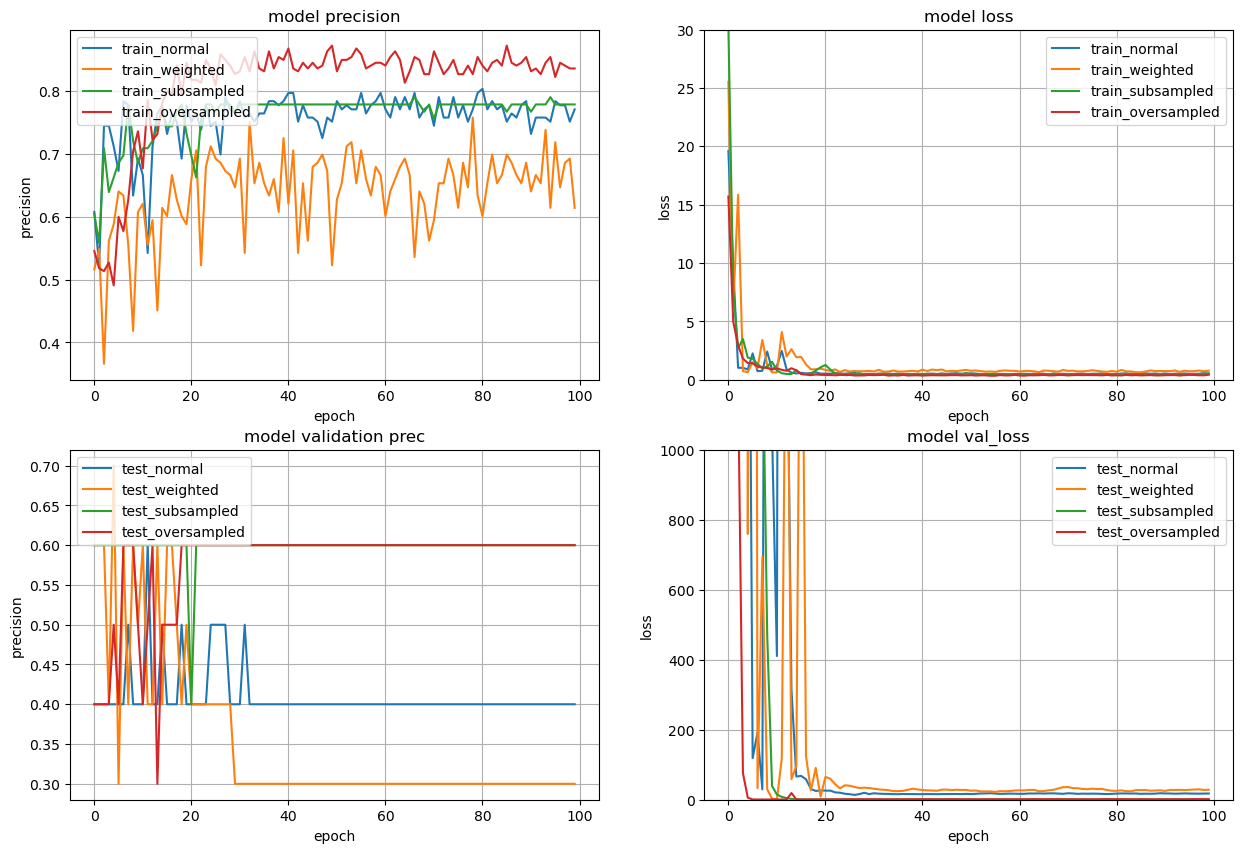

In [27]:
compare_hist(hist_dic_datagen, "training compare Resnet50_datagen")

### Comparing The F1-Score

In [28]:
# plot a F1 Score
def F1_hist(list_hist, figure_name):
    fig = plt.figure(figsize=(15,7))
    for key in list_hist:

         # summarize history for F1_score
        F1_score = 2 * (np.array(list_hist[key].history['precision']) *np.array(list_hist[key].history['recall']))/ (np.array(list_hist[key].history['precision'])+np.array(list_hist[key].history['recall']))
        val_F1_score =  (np.array(list_hist[key].history['val_precision']) *np.array(list_hist[key].history['val_recall']))/ (np.array(list_hist[key].history['val_precision'])+np.array(list_hist[key].history['val_recall']))
        
        ax1 = plt.subplot(121)
        plt.plot(F1_score, label =f'train_{key}')
        plt.title('model F1-Score')
        plt.ylabel('F1-Score')
        plt.xlabel('epoch')
        plt.legend( loc='lower right')
        plt.ylim([0,1])
      

        ax2 = plt.subplot(122)
        plt.plot(val_F1_score, label= f'test_{key}')
        plt.title('model val_F1-Score')
        plt.ylabel('F1-Score')
        plt.xlabel('epoch')
        plt.legend( loc='upper right')
        plt.ylim([0,1])

        
    ax1.grid()
    ax2.grid()
  
    plt.show()
    fig.savefig(f"./figures/{figure_name}.pdf")

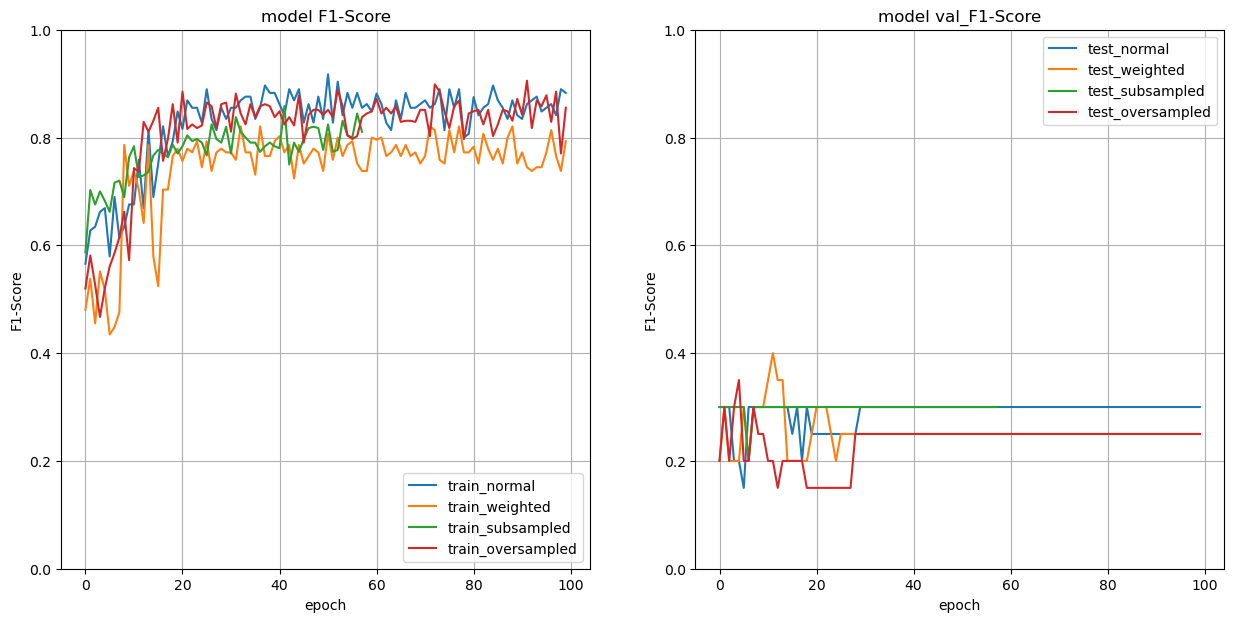

In [29]:
F1_hist(hist_dic, "Resnet50_F1_score")

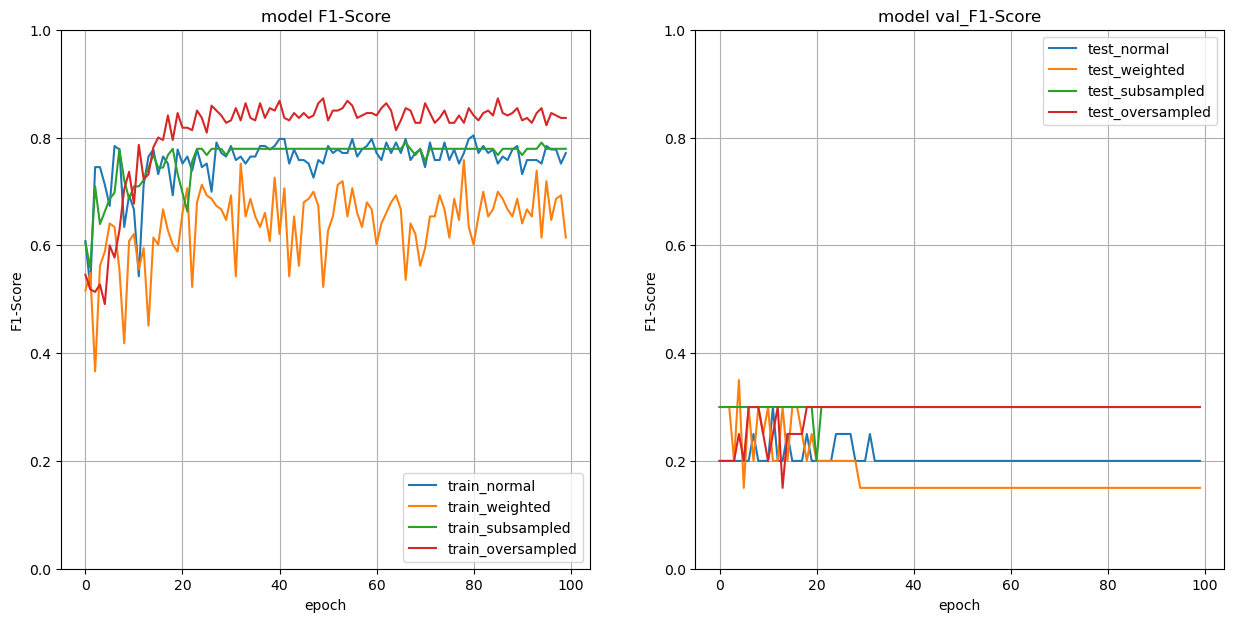

In [30]:
F1_hist(hist_dic_datagen,  "Resnet50_F1_score_datagen")